# Lung Disease Diagnosis - Model Tuning

Developer: Tung Nguyen

This notebook is a continuation of model-tuning-2.ipynb

The best performing model from model-tuning-1.ipynb and model-tuning-2.ipynb, based on AUPR, is the Xception model trained on a stratified subset of data. 

This notebook trains an Xception model on a stratified bootstrap of the full dataset (model-8a) and as a baseline, on the full dataset with no sampling applied (model-10a).

## Data Prep
---

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input as preprocess_input_Xception

from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_input_densenet

from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import AUC
from tensorflow.keras import backend as K
from tensorflow import cast, float32

from sklearn.metrics import roc_curve, precision_recall_curve, auc

In [14]:
df = pd.read_csv('../chest-x-ray-data/Data_Entry_2017.csv')
df = df.drop(['OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11'], axis=1, inplace=False)

mlb = MultiLabelBinarizer()
lbl_bins = mlb.fit_transform(df['Finding Labels'].str.split("|"))
df_bin = df.join(pd.DataFrame(lbl_bins, columns=mlb.classes_))

with open('../chest-x-ray-data/train_val_list.txt', 'r') as f:
    train_list = f.read().split('\n')

with open('../chest-x-ray-data/test_list.txt', 'r') as f:
    test_list = f.read().split('\n')

df_train = df_bin[df_bin['Image Index'].isin(train_list)]
df_test = df_bin[df_bin['Image Index'].isin(test_list)]

In [15]:
df_train.shape

(86524, 22)

In [16]:
labels = [lbl for lbl in mlb.classes_ if lbl != 'No Finding']

In [17]:
def plot_df_freq(df, labels, title=''):
    df_pos = df[labels].sum()

    ax = df_pos.plot(kind='bar', figsize=(15, 7), rot=20);
    ax.set_title(title);
    ax.set_xlabel('Labels');
    ax.set_ylabel('Frequency');
    ax.bar_label(ax.containers[0])
    
    return df_pos

### Data Sampling

In [18]:
# Stratified Sampling for Data Augmentation
stratified_sampled_train_df = pd.DataFrame([])

n = 6100

# Sample each label
for lbl in mlb.classes_:
    temp = df_train[df_train[lbl] == 1].sample(
        n,
        replace=True,
        random_state=1
    )
    
    stratified_sampled_train_df = pd.concat([stratified_sampled_train_df, temp])

In [19]:
stratified_sampled_train_df.shape

(91500, 22)

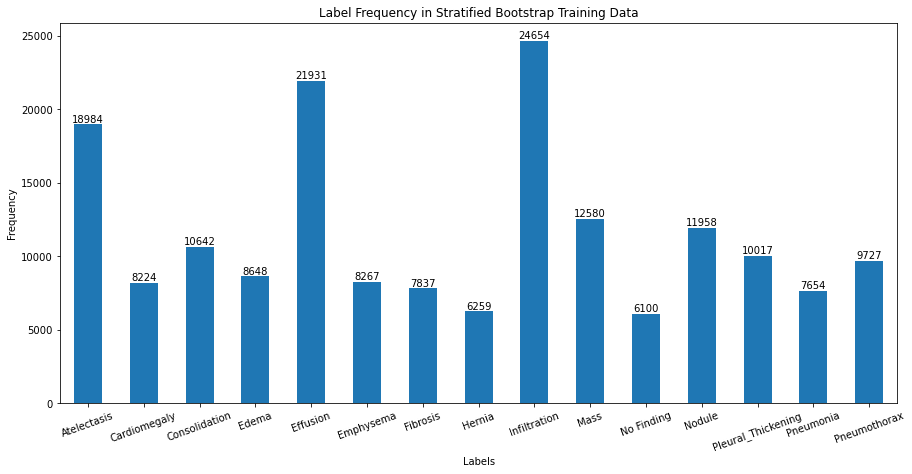

In [20]:
plot_df_freq(stratified_sampled_train_df, mlb.classes_, title='Label Frequency in Stratified Bootstrap Training Data');

### Helper Functions

In [21]:
def plot_losses(model_history, figsize=(15, 10)):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.plot(model_history.history['val_loss'], 'r-o')
    ax.plot(model_history.history['loss'], 'b-o')
    ax.set_title('Training vs. Validation Loss')
    ax.legend(['Validation Loss', 'Training Loss'])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')

In [22]:
def datagen_from_df(train_df, x_col, y_cols, data_dir, preproc_func=None, target_size=(256, 256), val_split=0.2, batch_size=64, color_mode='rgb', random_state=1):

    datagen = ImageDataGenerator(
        preprocessing_function=preproc_func,
        validation_split=val_split,
        horizontal_flip = True, 
        vertical_flip = False, 
        height_shift_range= 0.05, 
        width_shift_range=0.1, 
        rotation_range=5, 
        shear_range = 0.1,
        fill_mode = 'reflect',
        zoom_range=0.15,
    )

    train_generator = datagen.flow_from_dataframe(
        train_df,   
        data_dir,
        shuffle=True,
        batch_size=batch_size,
        class_mode='raw',
        color_mode=color_mode,
        target_size=target_size,
        x_col=x_col,
        y_col=y_cols,
        subset='training',
        seed=random_state
    )

    validation_generator = datagen.flow_from_dataframe(
        train_df,
        data_dir,
        shuffle=False,
        batch_size=batch_size,
        class_mode='raw',
        color_mode=color_mode,
        target_size=target_size,
        x_col=x_col,
        y_col=y_cols,
        subset='validation',
        seed=random_state
    )
    
    return train_generator, validation_generator

In [11]:
# Callbacks
early = EarlyStopping(
    monitor="val_loss",
    mode="min", 
    patience=8
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,
    patience=4, 
    min_lr=0.00001
)

chkpt = {}    
base_path = './models/'

for i in ['8a', '8b']:

    chkpt[i] = ModelCheckpoint(
        base_path + 'model-' + str(i) + '.h5', 
        monitor='val_loss',
        verbose=1, 
        save_best_only=True, 
        mode='min', 
    )

## Models
---

### DataGenerators

In [10]:
data_dir = '../chest-x-ray-data/imgs/'

In [23]:
train_gen = {}
val_gen = {}

train_gen['8a'], val_gen['8a'] = datagen_from_df(
    stratified_sampled_train_df, 
    x_col = 'Image Index', 
    y_cols = labels, 
    data_dir = data_dir, 
    preproc_func = preprocess_input_Xception, 
    target_size = (256, 256), 
    val_split = 0.2, 
    batch_size = 64, 
    color_mode = 'rgb', 
    random_state = 1
    )

train_gen['8b'], val_gen['8b'] = datagen_from_df(
    df_train, 
    x_col = 'Image Index', 
    y_cols = labels, 
    data_dir = data_dir, 
    preproc_func = preprocess_input_Xception, 
    target_size = (256, 256), 
    val_split = 0.2, 
    batch_size = 64, 
    color_mode = 'rgb', 
    random_state = 1
    )

Found 73200 validated image filenames.
Found 18300 validated image filenames.
Found 69220 validated image filenames.
Found 17304 validated image filenames.


### Model 8a

In [12]:
# Base Models
base_model_Xc_1 = Xception(
    include_top=False,
    weights="imagenet",
    pooling="avg",
    input_shape=(256, 256, 3)
)

output_layer_Xc_1 = Dense(len(labels), activation='sigmoid')(base_model_Xc_1.output)
model_Xc_1 = Model(base_model_Xc_1.input, output_layer_Xc_1)

for layer in model_Xc_1.layers:
    layer.trainable = True

In [13]:
model_Xc_1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics = [
        AUC(curve='PR', multi_label=True, num_labels=len(labels)), 
        AUC(curve='ROC', multi_label=True, num_labels=len(labels))
        ]
)

In [14]:
history_8a = model_Xc_1.fit(
    train_gen['8a'], 
    validation_data=val_gen['8a'],
    epochs = 40,
    callbacks = [chkpt['8a'], early, reduce_lr]
)

Epoch 1/40
1144/1144 [==============================] - ETA: 0s - loss: 0.2830 - auc: 0.4454 - auc_1: 0.8049
Epoch 1: val_loss improved from inf to 0.40230, saving model to ./models/model-8a.h5
1144/1144 [==============================] - 1682s 1s/step - loss: 0.2830 - auc: 0.4454 - auc_1: 0.8049 - val_loss: 0.4023 - val_auc: 0.3842 - val_auc_1: 0.7899 - lr: 0.0010
Epoch 2/40
1144/1144 [==============================] - ETA: 0s - loss: 0.2300 - auc: 0.6164 - auc_1: 0.8821
Epoch 2: val_loss improved from 0.40230 to 0.39462, saving model to ./models/model-8a.h5
1144/1144 [==============================] - 1693s 1s/step - loss: 0.2300 - auc: 0.6164 - auc_1: 0.8821 - val_loss: 0.3946 - val_auc: 0.4377 - val_auc_1: 0.8217 - lr: 0.0010
Epoch 3/40
1144/1144 [==============================] - ETA: 0s - loss: 0.1836 - auc: 0.7509 - auc_1: 0.9280
Epoch 3: val_loss improved from 0.39462 to 0.35989, saving model to ./models/model-8a.h5
1144/1144 [==============================] - 1691s 1s/step - l

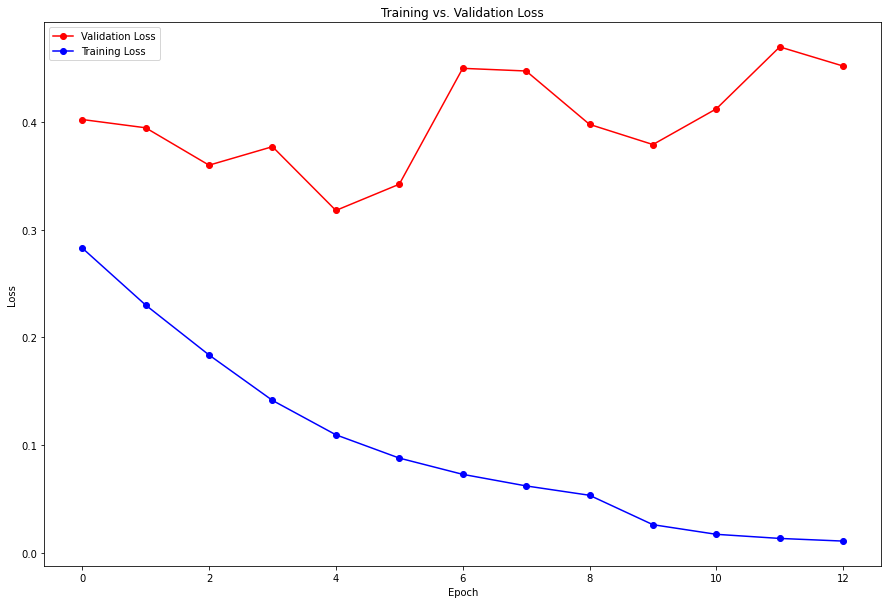

In [15]:
plot_losses(history_8a)

### Model 8b

In [14]:
# Base Models
base_model_Xc_2 = Xception(
    include_top=False,
    weights="imagenet",
    pooling="avg",
    input_shape=(256, 256, 3)
)

output_layer_Xc_2 = Dense(len(labels), activation='sigmoid')(base_model_Xc_2.output)
model_Xc_2 = Model(base_model_Xc_2.input, output_layer_Xc_2)

for layer in model_Xc_2.layers:
    layer.trainable = True

In [15]:
model_Xc_2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics = [
        AUC(curve='PR', multi_label=True, num_labels=len(labels)), 
        AUC(curve='ROC', multi_label=True, num_labels=len(labels))
        ]
)

In [16]:
history_8b = model_Xc_2.fit(
    train_gen['8b'], 
    validation_data=val_gen['8b'],
    epochs = 40,
    callbacks = [chkpt['8b'], early, reduce_lr]
)

Epoch 1/40
1082/1082 [==============================] - ETA: 0s - loss: 0.1489 - auc: 0.1299 - auc_1: 0.7320
Epoch 1: val_loss improved from inf to 0.16599, saving model to ./models/model-8b.h5
1082/1082 [==============================] - 1612s 1s/step - loss: 0.1489 - auc: 0.1299 - auc_1: 0.7320 - val_loss: 0.1660 - val_auc: 0.1353 - val_auc_1: 0.6996 - lr: 0.0010
Epoch 2/40
1082/1082 [==============================] - ETA: 0s - loss: 0.1395 - auc: 0.1830 - auc_1: 0.7819
Epoch 2: val_loss improved from 0.16599 to 0.13725, saving model to ./models/model-8b.h5
1082/1082 [==============================] - 1614s 1s/step - loss: 0.1395 - auc: 0.1830 - auc_1: 0.7819 - val_loss: 0.1373 - val_auc: 0.1589 - val_auc_1: 0.7769 - lr: 0.0010
Epoch 3/40
1082/1082 [==============================] - ETA: 0s - loss: 0.1363 - auc: 0.2030 - auc_1: 0.7951
Epoch 3: val_loss improved from 0.13725 to 0.13190, saving model to ./models/model-8b.h5
1082/1082 [==============================] - 1616s 1s/step - l

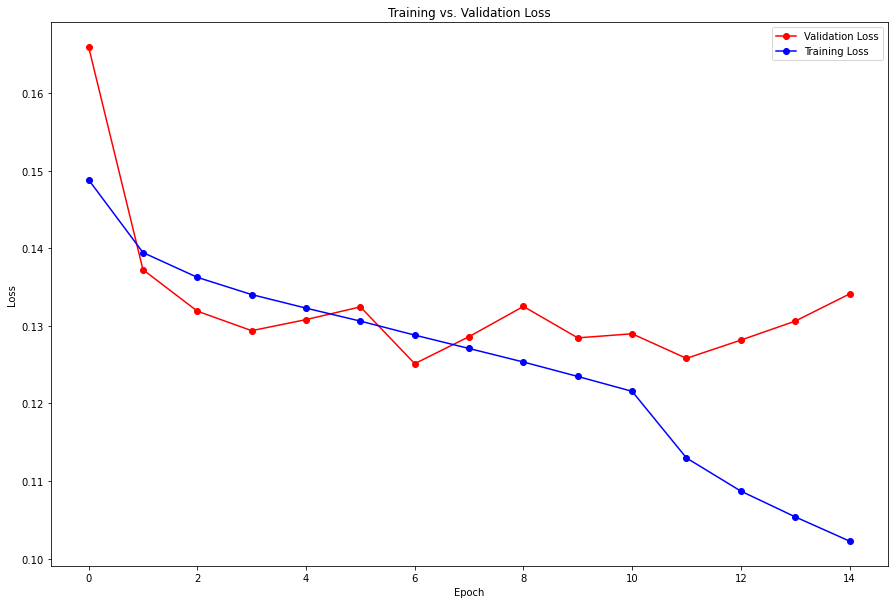

In [17]:
plot_losses(history_8b)

## Model Evaluation
---

In [8]:
import csv
from tensorflow.keras.models import load_model

In [48]:
def plot_roc_auc(y_true, y_pred, labels, model_name, file_path, csv_writer, figsize=(15, 10)):
    
    csv_writer.writerow(['label', 'fpr', 'tpr', 'threshold'])
    areas = {}

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    for i, lbl in enumerate(labels):
        fpr, tpr, thresholds = roc_curve(y_true[:, i], y_pred[:, i])
        areas[lbl] = auc(fpr, tpr)
        ax.plot(fpr, tpr, label = 'Score = %s (AUC: %0.5f)'  % (lbl, areas[lbl]))
        csv_writer.writerows(zip([lbl] * len(fpr), fpr, tpr, thresholds))

    ax.legend()
    ax.set_title('ROC Curves - ' + model_name);
    ax.set_xlabel('False Positive Rate (FPR)');
    ax.set_ylabel('True Positive Rate (TPR)');
    fig.savefig(file_path)
    plt.close(fig)

    return areas

def plot_precision_recall_auc(y_true, y_pred, labels, model_name, file_path, csv_writer, figsize=(15, 10)):

    csv_writer.writerow(['pr', 'rc', 'threshold'])
    areas = {}

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    for i, lbl in enumerate(labels):
        pr, rc, thresholds = precision_recall_curve(y_true[:, i], y_pred[:, i])
        areas[lbl] = auc(rc, pr)
        ax.plot(rc, pr, label = 'Score = %s (AUC: %0.5f)'  % (lbl, areas[lbl]))
        csv_writer.writerows(zip([lbl] * len(pr), pr, rc, thresholds))

    ax.legend()
    ax.set_title('Precision-Recall Curve - ' + model_name);
    ax.set_xlabel('Recall');
    ax.set_ylabel('Precision');
    fig.savefig(file_path)
    plt.close(fig)

    return areas

In [20]:
for i in ['8a', '8b']:
    model_name = 'model-' + str(i)

    roc_jpg = './results/roc-' + model_name + '.jpg'
    roc_csv = './results/roc-' + model_name + '.csv'
    auroc_csv = './results/auroc-' + model_name + '.csv'
    pr_jpg = './results/pr-' + model_name + '.jpg'
    pr_csv = './results/pr-' + model_name + '.csv'
    aupr_csv= './results/aupr-' + model_name + '.csv'
    
    model = load_model('./models/' + model_name + '.h5', compile=False)

    val_gen[i].reset()
    y_true = val_gen[i].labels
    y_pred = model.predict(val_gen[i], batch_size=64, verbose=True)

    with open(roc_csv, 'w') as f:
        csv_writer = csv.writer(f)
        areas = plot_roc_auc(y_true, y_pred, labels, model_name, roc_jpg, csv_writer, figsize=(15, 10))
    
    with open(auroc_csv, 'w') as f:
        dict_writer = csv.DictWriter(f, fieldnames=labels)
        dict_writer.writeheader()
        dict_writer.writerow(areas)

    with open(pr_csv, 'w') as f:
        csv_writer = csv.writer(f)
        areas = plot_precision_recall_auc(y_true, y_pred, labels, model_name, pr_jpg, csv_writer, figsize=(15, 10))

    with open(aupr_csv, 'w') as f:
        dict_writer = csv.DictWriter(f, fieldnames=labels)
        dict_writer.writeheader()
        dict_writer.writerow(areas)

271/271 [==============================] - 432s 2s/step


### Area Under ROC Curve

In [21]:
import os

def highlight_max(s, props=''):
    return np.where(s == np.max(s.values), props, '')

def highlight_min(s, props=''):
    return np.where(s == np.min(s.values), props, '')

results_dir = r'./results/'
csv_files = sorted([x for x in os.listdir(results_dir) if 'csv' in x and 'auroc' in x])

df_list = [pd.read_csv(results_dir + file).assign(File=file) for file in csv_files]

df = pd.concat(df_list, ignore_index=True)
df = df.set_index('File')
df = df.transpose()
df = df[['auroc-model-' + str(x) + '.csv' for x in ['8a', '8b']]]

df.style.apply(
    highlight_max, props='color:darkgreen;background-color:lightgreen', axis=1
        ).apply(
    highlight_min, props='color:darkred;background-color:salmon', axis=1
        ).set_caption('SUMMARY - Area Under ROC Curve')

File,auroc-model-8a.csv,auroc-model-8b.csv
Atelectasis,0.767044,0.823810
Cardiomegaly,0.840857,0.915844
Consolidation,0.718402,0.802401
Edema,0.984834,0.895386
Effusion,0.827132,0.883136
Emphysema,0.990625,0.832571
Fibrosis,0.975805,0.774187
Hernia,0.999994,0.827583
Infiltration,0.730827,0.710906
Mass,0.926340,0.846635


In [22]:
print('Average AUROC:')
for ind, col in df.iteritems():
    print('%s: %0.6f' % (ind, col.mean()))

Average AUROC:
auroc-model-8a.csv: 0.893169
auroc-model-8b.csv: 0.811231


### Area Under PR Curve

In [23]:
csv_files = sorted([x for x in os.listdir(results_dir) if 'csv' in x and 'aupr' in x])

df_list = [pd.read_csv(results_dir + file).assign(File=file) for file in csv_files]

df = pd.concat(df_list, ignore_index=True)
df = df.set_index('File')
df = df.transpose()
df = df[['aupr-model-' + str(x) + '.csv' for x in ['8a', '8b']]]

df.style.apply(
    highlight_max, props='color:darkgreen;background-color:lightgreen', axis=1
        ).apply(
    highlight_min, props='color:darkred;background-color:salmon', axis=1
        ).set_caption("SUMMARY - Area Under PR Curve")

File,aupr-model-8a.csv,aupr-model-8b.csv
Atelectasis,0.755143,0.328680
Cardiomegaly,0.788499,0.349445
Consolidation,0.661086,0.126924
Edema,0.760088,0.124991
Effusion,0.698496,0.479064
Emphysema,0.814216,0.220804
Fibrosis,0.732372,0.087505
Hernia,0.997512,0.192267
Infiltration,0.497035,0.273046
Mass,0.652650,0.244508


In [24]:
print('Average AUPR:')
for ind, col in df.iteritems():
    print('%s: %0.6f' % (ind, col.mean()))

Average AUPR:
aupr-model-8a.csv: 0.708737
aupr-model-8b.csv: 0.211567


# Conclusions

* Although both models performed similarly when comparing AUROC, model 8a is clearly the better model as indicated by the AUPR. 

* model 8b was trained on the full dataset without sampling methods and is used as a control experiment.

* model 8a will be deployed as a streamlit app.

![image](./results/roc-model-8a.jpg)

![image](./results/pr-model-8a.jpg)

## Selection of Classification Threshold for Deployment

* Picking a classification threshold relies heavily on domain-specific knowledge as well as the specific use-case of the model.

* Plots and data in this section were generated to characterize the behavior of the model under different thresholds, and is meant to be an aid for threshold selection if this were a real deployment.

* Due to a lack of a use-case or domain-specific knowledge for this project, a threshold = 0.5 will be selected.

In [6]:
from sklearn.metrics import accuracy_score, hamming_loss, precision_score, recall_score, f1_score, confusion_matrix

In [24]:
model = load_model('./models/model-8a.h5', compile=False)

val_gen['8a'].reset()
y_true = val_gen['8a'].labels
y_pred = model.predict(val_gen['8a'], batch_size=128, verbose=True)

286/286 [==============================] - 283s 988ms/step


In [25]:
def prob2class(y_pred, threshold):
    return np.array([[1. if x >= threshold else 0. for x in arr] for arr in y_pred])

In [26]:
# Calculate multi-label metrics, averaged over samples

thresholds = np.linspace(0.01, 0.99, 99)

metrics_df = pd.DataFrame(columns=['threshold', 'accuracy', 'hamming_loss', 'precision', 'recall', 'f1'])
for threshold in thresholds:

    # Round-off issue with Apple M1 & numpy
    threshold = round(threshold, 2)
    
    y_pred_threshold = prob2class(y_pred, threshold)

    temp = pd.DataFrame({
        'threshold': [threshold],
        'accuracy': [accuracy_score(y_true, y_pred_threshold, normalize=True, sample_weight=None)],
        'hamming_loss': [hamming_loss(y_true, y_pred_threshold)],
        'precision': [precision_score(y_true, y_pred_threshold, average='samples', zero_division=0)], 
        'recall': [recall_score(y_true, y_pred_threshold, average='samples')],
        'f1': [f1_score(y_true, y_pred_threshold, average='samples')]
    })

    metrics_df = pd.concat([metrics_df, temp])

In [32]:
metrics_df

,threshold,accuracy,hamming_loss,precision,recall,f1
0,0.01,0.010164,0.414133,0.263942,0.915647,0.385418
0,0.02,0.016721,0.358646,0.285655,0.864506,0.40351
0,0.03,0.02306,0.323821,0.300916,0.828747,0.414841
0,0.04,0.027814,0.298731,0.312494,0.796612,0.421858
0,0.05,0.03224,0.279477,0.32107,0.768625,0.426028
...,...,...,...,...,...,...
0,0.95,0.037268,0.12281,0.189676,0.110154,0.132884
0,0.96,0.033224,0.124415,0.172588,0.099102,0.120041
0,0.97,0.027923,0.126183,0.153835,0.08648,0.10554
0,0.98,0.022131,0.128513,0.13171,0.072085,0.088832


In [39]:
metrics_df.max()

threshold           0.99
accuracy        0.133388
hamming_loss    0.414133
precision       0.413526
recall          0.915647
f1              0.441507
dtype: object

In [40]:
metrics_df.min()

threshold           0.01
accuracy        0.010164
hamming_loss    0.112248
precision       0.099549
recall          0.052697
f1              0.065599
dtype: object

/Users/tungnguyen/miniforge3/envs/tf-gpu/lib/python3.9/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


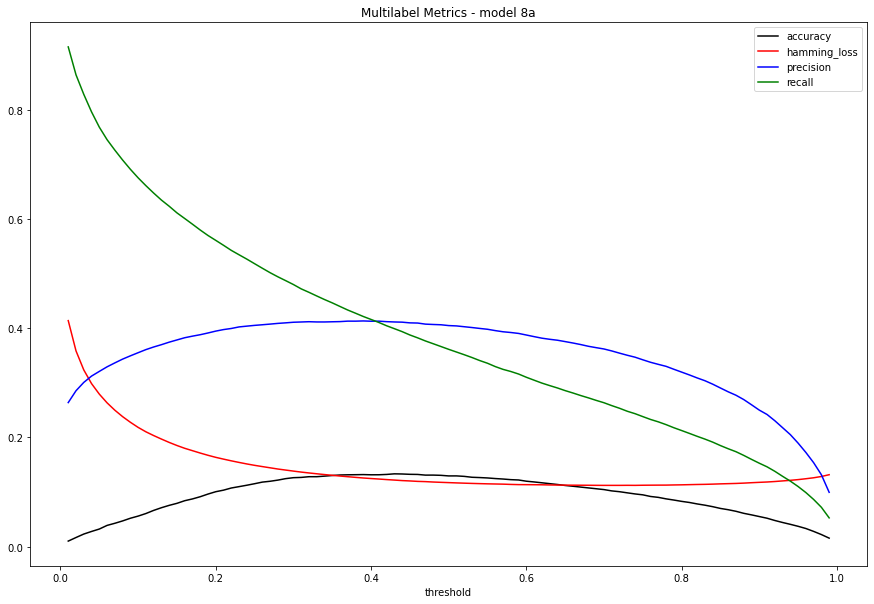

In [28]:
metrics_df.plot(
    kind='line', 
    x='threshold', 
    y=['accuracy', 'hamming_loss', 'precision', 'recall'], 
    color=['black', 'red', 'blue', 'green'], 
    figsize=(15, 10)
    )
ax = plt.gca()
ax.set_title('Multilabel Metrics - model 8a');

* Accuracy score in the plot above is a harsh metric as the set of labels predicted for a sample must exactly match the corresponding labels in y_true

* Hamming loss is a less harsh metric, and is the fraction of labels that are incorrectly predicted, (e.g. 1 - accuracy for the binary case). 

* Precision, recall, and f1 in the plot above is calculated for each instance, then averaged over all samples.

In [29]:
# Calculate binary metrics for each individual label
ind_metrics_df = pd.DataFrame(columns=['label', 'threshold', 'accuracy', 'precision', 'recall', 'f1'])
for threshold in thresholds:
    
    # Round-off issue with Apple M1 & numpy
    threshold = round(threshold, 2)
    y_pred_threshold = prob2class(y_pred, threshold)

    for i, lbl in enumerate(labels):

        tn, fp, fn, tp = confusion_matrix(y_true[:, i], y_pred_threshold[:, i]).ravel()
        
        temp = pd.DataFrame({
            'label': [lbl],
            'threshold': [threshold],
            'accuracy': [accuracy_score(y_true[:, i], y_pred_threshold[:, i])],
            'precision': [precision_score(y_true[:, i], y_pred_threshold[:, i])], 
            'recall': [recall_score(y_true[:, i], y_pred_threshold[:, i])],
            'f1': [f1_score(y_true[:, i], y_pred_threshold[:, i])],
            'tn': [tn],
            'fp': [fp],
            'fn': [fn],
            'tp': [tp]
            })
        ind_metrics_df = pd.concat([ind_metrics_df, temp])

In [33]:
ind_metrics_df

,label,threshold,accuracy,precision,recall,f1,tn,fp,fn,tp
0,Atelectasis,0.01,0.562951,0.512714,0.944345,0.664598,2378.0,7531.0,467.0,7924.0
0,Cardiomegaly,0.01,0.701366,0.545427,0.837506,0.660622,7516.0,4433.0,1032.0,5319.0
0,Consolidation,0.01,0.461202,0.406978,0.942961,0.568566,1943.0,9467.0,393.0,6497.0
0,Edema,0.01,0.806339,0.122924,0.99002,0.218695,14260.0,3539.0,5.0,496.0
0,Effusion,0.01,0.360546,0.313993,0.991822,0.476982,1262.0,11658.0,44.0,5336.0
...,...,...,...,...,...,...,...,...,...,...
0,Mass,0.99,0.934699,0.872263,0.170836,0.285714,16866.0,35.0,1160.0,239.0
0,Nodule,0.99,0.944098,0.933884,0.100177,0.180945,17164.0,8.0,1015.0,113.0
0,Pleural_Thickening,0.99,0.963989,1.0,0.091034,0.166877,17575.0,0.0,659.0,66.0
0,Pneumonia,0.99,0.991475,0.888889,0.615385,0.727273,17936.0,26.0,130.0,208.0


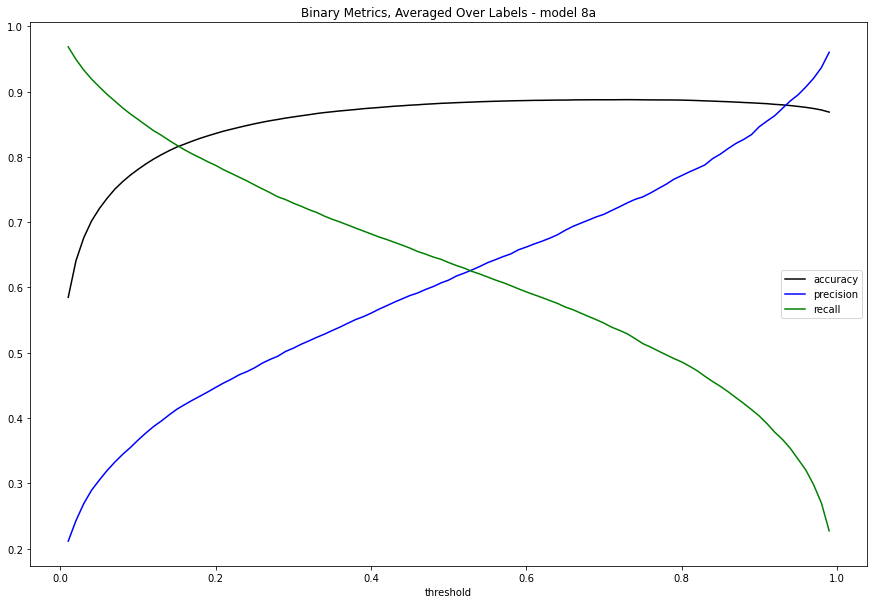

In [111]:
ind_metrics_df[['threshold', 'accuracy', 'precision', 'recall']].groupby('threshold').agg('mean').plot(kind='line', color=['black', 'blue', 'green'], figsize=(15, 10))
ax = plt.gca()
ax.set_title('Binary Metrics - model 8a');

* The plot above treats the problem as multiple binary classification problems, calculate metrics, and then averages over the labels.

* The precision-recall trade-off can also be clearly seen.

In [104]:
metrics_df[metrics_df.threshold == 0.5]

,threshold,accuracy,hamming_loss,precision,recall,f1
0,0.5,0.130984,0.117615,0.40571,0.360712,0.361031


In [43]:
pd.set_option('display.max_rows', 14)
ind_metrics_df[ind_metrics_df.threshold == 0.5]

,label,threshold,accuracy,precision,recall,f1,tn,fp,fn,tp
0,Atelectasis,0.5,0.674699,0.812404,0.377786,0.515741,9177.0,732.0,5221.0,3170.0
0,Cardiomegaly,0.5,0.76,0.938648,0.330027,0.48835,11812.0,137.0,4255.0,2096.0
0,Consolidation,0.5,0.706393,0.758609,0.322932,0.453018,10702.0,708.0,4665.0,2225.0
0,Edema,0.5,0.979727,0.603175,0.758483,0.671972,17549.0,250.0,121.0,380.0
0,Effusion,0.5,0.770328,0.589288,0.721933,0.648902,10213.0,2707.0,1496.0,3884.0
0,Emphysema,0.5,0.989016,0.790932,0.726852,0.757539,17785.0,83.0,118.0,314.0
0,Fibrosis,0.5,0.978962,0.468852,0.824207,0.597701,17629.0,324.0,61.0,286.0
0,Hernia,0.5,0.999344,0.785714,1.0,0.88,18244.0,12.0,0.0,44.0
0,Infiltration,0.5,0.789781,0.568783,0.310171,0.401431,13163.0,978.0,2869.0,1290.0
0,Mass,0.5,0.891749,0.398181,0.813438,0.534649,15181.0,1720.0,261.0,1138.0


* Using the default threshold of 0.5, the model has high accuracy for most diseases except for Atelectasis and Hernia

* The model had the highest accuracy for Hernia, which is one of the underrepresented labels. However, it's precision is ~0.78, with no false negatives in the validation set.

# AUC on Test Data - model 8a

* Final model metrics for model 8a are calculated below

In [45]:
def test_datagen_from_df(test_df, x_col, y_cols, data_dir, preproc_func=None, target_size=(256, 256), batch_size=64, color_mode='rgb', random_state=1):

    datagen = ImageDataGenerator(
        preprocessing_function=preproc_func
    )

    test_generator = datagen.flow_from_dataframe(
        test_df,   
        data_dir,
        shuffle=False,
        batch_size=batch_size,
        class_mode='raw',
        color_mode=color_mode,
        target_size=target_size,
        x_col=x_col,
        y_col=y_cols,
        seed=random_state
    )

    return test_generator

In [46]:
test_gen = {}

test_gen['8a'] = test_datagen_from_df(
    df_test, 
    x_col = 'Image Index', 
    y_cols = labels, 
    data_dir = data_dir, 
    preproc_func = preprocess_input_Xception, 
    target_size = (256, 256), 
    batch_size = 64, 
    color_mode = 'rgb', 
    random_state = 1
    )

Found 25596 validated image filenames.


In [49]:
for i in ['8a']:
    model_name = 'model-' + str(i)

    roc_jpg = './results/test-data-roc-' + model_name + '.jpg'
    roc_csv = './results/test-data-roc-' + model_name + '.csv'
    auroc_csv = './results/test-data-auroc-' + model_name + '.csv'
    pr_jpg = './results/test-data-pr-' + model_name + '.jpg'
    pr_csv = './results/test-data-pr-' + model_name + '.csv'
    aupr_csv= './results/test-data-aupr-' + model_name + '.csv'
    
    model = load_model('./models/' + model_name + '.h5', compile=False)

    y_true = test_gen[i].labels
    y_pred = model.predict(test_gen[i], batch_size=128, verbose=True)

    with open(roc_csv, 'w') as f:
        csv_writer = csv.writer(f)
        areas = plot_roc_auc(y_true, y_pred, labels, model_name, roc_jpg, csv_writer, figsize=(15, 10))
    
    with open(auroc_csv, 'w') as f:
        dict_writer = csv.DictWriter(f, fieldnames=labels)
        dict_writer.writeheader()
        dict_writer.writerow(areas)

    with open(pr_csv, 'w') as f:
        csv_writer = csv.writer(f)
        areas = plot_precision_recall_auc(y_true, y_pred, labels, model_name, pr_jpg, csv_writer, figsize=(15, 10))

    with open(aupr_csv, 'w') as f:
        dict_writer = csv.DictWriter(f, fieldnames=labels)
        dict_writer.writeheader()
        dict_writer.writerow(areas)

400/400 [==============================] - 255s 637ms/step


![image](./results/test-data-roc-model-8a.jpg)

![image](./results/test-data-pr-model-8a.jpg)

In [50]:
# Calculate multi-label metrics, averaged over samples
thresholds = [0.5]

metrics_df = pd.DataFrame(columns=['threshold', 'accuracy', 'hamming_loss', 'precision', 'recall', 'f1'])
for threshold in thresholds:

    # Round-off issue with Apple M1 & numpy
    threshold = round(threshold, 2)
    
    y_pred_threshold = prob2class(y_pred, threshold)

    temp = pd.DataFrame({
        'threshold': [threshold],
        'accuracy': [accuracy_score(y_true, y_pred_threshold, normalize=True, sample_weight=None)],
        'hamming_loss': [hamming_loss(y_true, y_pred_threshold)],
        'precision': [precision_score(y_true, y_pred_threshold, average='samples', zero_division=0)], 
        'recall': [recall_score(y_true, y_pred_threshold, average='samples')],
        'f1': [f1_score(y_true, y_pred_threshold, average='samples')]
    })

    metrics_df = pd.concat([metrics_df, temp])

metrics_df

/Users/tungnguyen/miniforge3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tungnguyen/miniforge3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


,threshold,accuracy,hamming_loss,precision,recall,f1
0,0.5,0.241952,0.106931,0.20402,0.201777,0.184526


In [51]:
# Calculate binary metrics for each individual label
ind_metrics_df = pd.DataFrame(columns=['label', 'threshold', 'accuracy', 'precision', 'recall', 'f1'])
for threshold in thresholds:
    
    # Round-off issue with Apple M1 & numpy
    threshold = round(threshold, 2)
    y_pred_threshold = prob2class(y_pred, threshold)

    for i, lbl in enumerate(labels):

        tn, fp, fn, tp = confusion_matrix(y_true[:, i], y_pred_threshold[:, i]).ravel()
        
        temp = pd.DataFrame({
            'label': [lbl],
            'threshold': [threshold],
            'accuracy': [accuracy_score(y_true[:, i], y_pred_threshold[:, i])],
            'precision': [precision_score(y_true[:, i], y_pred_threshold[:, i])], 
            'recall': [recall_score(y_true[:, i], y_pred_threshold[:, i])],
            'f1': [f1_score(y_true[:, i], y_pred_threshold[:, i])],
            'tn': [tn],
            'fp': [fp],
            'fn': [fn],
            'tp': [tp]
            })
        ind_metrics_df = pd.concat([ind_metrics_df, temp])

ind_metrics_df

,label,threshold,accuracy,precision,recall,f1,tn,fp,fn,tp
0,Atelectasis,0.5,0.831263,0.280405,0.202501,0.235169,20613.0,1704.0,2615.0,664.0
0,Cardiomegaly,0.5,0.949641,0.350543,0.241347,0.285873,24049.0,478.0,811.0,258.0
0,Consolidation,0.5,0.88592,0.122351,0.098623,0.109213,22497.0,1284.0,1636.0,179.0
0,Edema,0.5,0.942843,0.18128,0.165405,0.172979,23980.0,691.0,772.0,153.0
0,Effusion,0.5,0.756954,0.389665,0.592529,0.470147,16615.0,4323.0,1898.0,2760.0
0,Emphysema,0.5,0.956868,0.491704,0.298262,0.371298,24166.0,337.0,767.0,326.0
0,Fibrosis,0.5,0.975582,0.104167,0.057471,0.074074,24946.0,215.0,410.0,25.0
0,Hernia,0.5,0.99664,0.5,0.348837,0.410959,25480.0,30.0,56.0,30.0
0,Infiltration,0.5,0.698156,0.372027,0.383835,0.377839,15524.0,3960.0,3766.0,2346.0
0,Mass,0.5,0.852282,0.2303,0.496568,0.314664,20947.0,2901.0,880.0,868.0
